<a href="https://colab.research.google.com/github/HannaRF/Transfer-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practical notebook: Transfer learning and fine-tuning
---
This notebook is based on <a href="https://www.tensorflow.org/tutorials/images/transfer_learning" class="external">an official notebook from tensorflow</a>.

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

Network to be use: VGG16

![Image in a markdown cell](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os


## Prepare data
---

In [ ]:
# # Run this cell to download the Cats and Dogs set
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# train_dir = os.path.join(PATH, 'train')
# validation_dir = os.path.join(PATH, 'validation')

# BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
# CLASSES = 2

In [ ]:
# # Define training and validation dataloader

# # Define training from the training directory
# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,

#                                                             image_size=IMG_SIZE)
# # Split validation set into 50% validation and 50% test
# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=True,
#                                                                  validation_split=0.5,
#                                                                  subset="training",
#                                                                  seed=1337,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)

# test_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
#                                                                  shuffle=True,
#                                                                  validation_split=0.5,
#                                                                  subset="validation",
#                                                                  seed=1337,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE)

# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking.
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# plt.figure(figsize=(16, 2))
# for images, labels in validation_dataset.take(1):
#   for i in range(32):
#     ax = plt.subplot(2, 16, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# plt.figure(figsize=(16, 2))
# for images, labels in test_dataset.take(1):
#   for i in range(32):
#     ax = plt.subplot(2, 16, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Data augmentation
---

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomZoom(
# 				height_factor=(-0.05, -0.15),
# 				width_factor=(-0.05, -0.15)),
# ])

# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')




---


## Transfer Learning with VGG16
---
Loading pre-trained weights

In [ ]:
def VGG16(include_top=False, weights='imagenet',input_tensor=None,input_shape=None,pooling=False):
  # Not loaded the last two fully connected layers which act as the classifier.
  # We are just loading the convolutional layers. Note: not specifying the shape of top layers,
  # the input tensor shape is (None, None, 3),so you can use them for any size of images.
  model = tf.keras.applications.vgg16.VGG16(
                                            include_top=include_top,
                                            weights=weights,
                                            input_tensor=input_tensor,
                                            input_shape=input_shape,
                                            pooling=pooling)

  return model


In [ ]:
# base_model = VGG16(input_shape=(160,160,3))
# base_model.summary()

---
Create a new network with base layers taken from VGG

In [ ]:
# # Freeze the convolutional base model
# base_model.trainable = False
# base_model.summary()

In [ ]:
# Freeze only specific layers of the base model
def freeze_layer(net,freeze_lay_name):

  # Getting layer number through layer name
  for layer_number, layer in enumerate(net.layers):
    if layer.name == freeze_lay_name:
      lay_nb = layer_number
      break

  # Froze layers
  for layer in base_model.layers[:lay_nb]:
    layer.trainable = False

  return base_model


# # Freeze up to specific layer of the base model
# base_model = VGG16(input_shape=(160,160,3))
# base_model = freeze_layer(base_model,'block5_pool')
# base_model.summary()


---
Add new trainable layers: a classification head, dense layers...

In [ ]:
# # Defining a global average pooling layer and a classfication layer
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(1)

# # Defining other layers to add at the end of the base model
# dense_1 = tf.keras.layers.Dense(64)

# # use the preprocessing method included with the model.
# preprocess_input = tf.keras.applications.vgg16.preprocess_input

# # Build a model by chaining together the data augmentation, rescaling,
# # base_model and feature extractor layers using the Keras Functional API.
# inputs = tf.keras.Input(shape=(160, 160, 3))

# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x)
# x = global_average_layer(x)

# # Add classification layer
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)
# model.summary()

# # Compile de model
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])


---
Train network and get training history

In [ ]:
def show_result(acc, val_acc, loss, val_loss):
    plt.rcParams['axes.facecolor']='white'
    f, axarr = plt.subplots(1 , 2)
    f.set_figwidth(10)

    # Accuracy
    axarr[0].plot(acc)
    axarr[0].plot(val_acc)
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'valid'], loc='upper left')

    # Loss
    axarr[1].plot(loss)
    axarr[1].plot(val_loss)
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'valid'], loc='upper left')

    plt.show()

In [ ]:
def Train(model, epochs, train_dataset, validation_dataset, test_dataset):

    print('Start training')
    # define file name to save the model
    file_name = 'best_model.h5'
    # create checkpoint callbacks to save best model for the validation set
    checkpointer = tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_accuracy', verbose=10, save_best_only=True)
    # create early stopp callbacks to stop training after not imporvment
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001,
                               mode = 'max', patience = 15)

    # Make first evaluation
    loss0, accuracy0 = model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))


    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset,
                        callbacks=[early_stop,checkpointer])


    show_result(history.history['accuracy'],
              history.history['val_accuracy'],
              history.history['loss'],
              history.history['val_loss'])

    del model
    model = tf.keras.models.load_model(file_name)
    loss_val = model.evaluate(validation_dataset)
    loss_test = model.evaluate(test_dataset)

    print("[Validation loss: %f , Validation acc.:%.2f%%]" %(loss_val[0] , 100 * loss_val[1]))
    print("[Test loss: %f , Test acc.:%.2f%%]" %(loss_test[0] , 100 * loss_test[1]))


---
Train the network

In [ ]:
# epochs = 50
# Train(model, epochs, train_dataset, validation_dataset,test_dataset)

---
## Class exercise
---
Observe the network performance for different configurations:
* Use pre-trained bottom layers of VGG up to layer name (VGG_LN)
* Extra dense layers (DL)

link pro docs para os resultados [https://docs.google.com/document/d/1y5ebDxYV8G7oZ-pomTfY_PdlD1mLGQtglwukNVNmByc/edit?usp=sharing]

Experiments || VGG_LN || DL || Aluno || Test Acc ||
--- || --- || --- || --- || --- ||
Conf_1 ||  **'block5_pool'**  ||  **None**   || 1 ||
Conf_2 ||  **'block5_pool'**  ||  **Dense_1**  || 2 ||
Conf_3 ||  **'block5_conv3'**  ||  **None**   || 3 ||
Conf_4 ||  **'block5_conv3'**  ||  **Dense_1**   || 4 ||
Conf_5 ||  **'block5_conv2'**  ||  **None**   || 5 ||
Conf_6 ||  **'block5_conv2'**  ||  **Dense_1**   || 6 ||
Conf_7 ||  **'block5_conv1'**  ||  **None**   || 7 ||
Conf_8 ||  **'block5_conv1'**  ||  **Dense_1**   || 8 ||
Conf_9 ||  **'block4_pool'**  ||  **None**   || 9 ||
Conf_10 ||  **'block4_pool'**  ||  **Dense_1**   || 10 ||
Conf_11 ||  **'block4_conv3'**  ||  **None**   || 11 ||
Conf_12 ||  **'block4_conv3'**  ||  **Dense_1**   || 12 ||
Conf_13 ||  **'block4_conv2'**  ||  **Dense_1**   || 13 ||
      

---
# HOMEWORK 1: Transfer learning.
---

**Objectives**:  Provide students with practical experience with \\
*	convolutional neural networks \\
*	VGG16, and \\
*	transfer learning

**Description**: The project consists of implementing and assessing the performance of a VGG16 used as “backbone” in three scenarios:
1.	Training from scratch
2.	Using a network pre-trained on ImageNet as a feature extractor
3.	Taking a network pre-trained on ImageNet and fine-tuning the layers

**Experiments**: The students are encouraged to evaluate and compare three approaches as illustrated in the figure and described next:

![](https://drive.google.com/uc?id=1Nh9bftFVrJ99Ncv02DqCoMBBH1h-NUij)

1.	Training from scratch: Use the VGG16 model with no prior training, remove the latest layer (prediction layer) and add a classifier. Train the model from scratch and evaluate.

2.	Using pre-trained network as feature extractor: Use the same model of Exp. 1, but with the VGG16 model pre-trained on ImageNet. Freeze all layers of ResNet50, train and evaluate the model.

3.	Fine-tuning the latest layers: take a pre-trained VGG16 model, unfreeze the last blocks acording to the following: \\
  3-a) - unfreeze the last convolutional blocks (from "block5_conv1"), train and evaluate the model. \\
  3-b) - unfreeze the last convolutional blocks (from "block4_conv1"), train and evaluate the model. \\
  3-c) - unfreeze all convolutional blocks, train and evaluate the model.


**Dataset**: Beans dataset --> Beans is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class. The images have dimension 500x500, resize all of them to 224x224. \\
*	Train url ('https://storage.googleapis.com/ibeans/train.zip') \\
*	Validation url: ('https://storage.googleapis.com/ibeans/validation.zip') \\
*	Test url: ('https://storage.googleapis.com/ibeans/test.zip') \\

Example to define the train dataloader:


In [ ]:
# _URL = 'https://storage.googleapis.com/ibeans/train.zip'
# path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

# train_dir = os.path.join(os.path.dirname(path_to_zip),'train')
# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)

# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                             shuffle=True,
#                                                             batch_size=BATCH_SIZE,
#                                                             image_size=IMG_SIZE)



Select  good  hyper-parameters values  for  your  training  (try  with  different ones). Use the same hyper-parameters configuration for the three experiments.

**Homework Report**: The final report must contain:
1.	A link to the shared notebook containing your code
2.	A pdf file reporting your experiments, includes the results in the form of a table, and discusse the results

Exp ||	train acc	|| train loss	|| val acc || val loss	|| test acc	|| test loss ||
--- || --- || --- || --- || --- || --- || --- ||
1 || --- || --- || --- || --- || --- || --- ||
2 || --- || --- || --- || --- || --- || --- ||
3-a) || --- || --- || --- || --- || --- || --- ||
3-b) || --- || --- || --- || --- || --- || --- ||
3-c) || --- || --- || --- || --- || --- || --- ||


# carga dos dados do exercício


In [ ]:
_URL = 'https://storage.googleapis.com/ibeans/train.zip'
path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

train_dir = os.path.join(os.path.dirname(path_to_zip),'train')


_URL = 'https://storage.googleapis.com/ibeans/validation.zip'
path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

val_dir = os.path.join(os.path.dirname(path_to_zip),'validation')



_URL = 'https://storage.googleapis.com/ibeans/test.zip'
path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

test_dir = os.path.join(os.path.dirname(path_to_zip),'train')



BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
# Define training and validation dataloader

# Define training from the training directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode = "categorical")
# Split validation set into 50% validation and 50% test
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 validation_split=0.5,
                                                                 subset="training",
                                                                 seed=1337,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = "categorical")

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 validation_split=0.5,
                                                                 subset="validation",
                                                                 seed=1337,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = "categorical")

class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Using 67 files for training.
Found 1034 files belonging to 3 classes.
Using 517 files for validation.


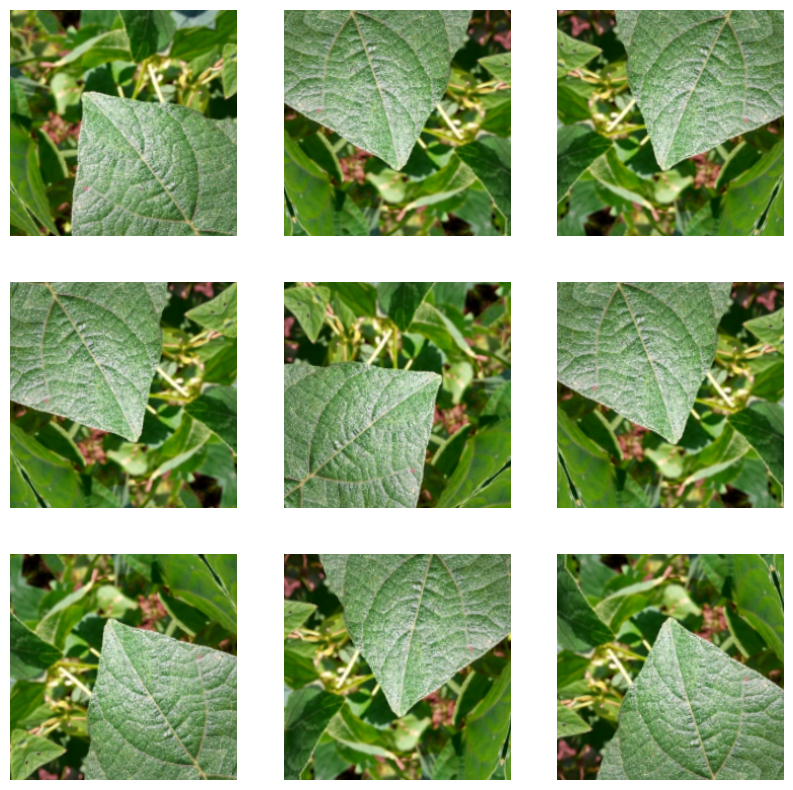

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
				height_factor=(-0.05, -0.15),
				width_factor=(-0.05, -0.15)),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Cenário 1 : Random Inicialization

(Não congelamos nada)

In [ ]:
# Ajustando o VGG16 aos dados de treino, além de remover o fine-tuning
base_model = VGG16(input_shape=(224,224,3), weights=None)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

Start training
3/3 [==============================] - 12s 460ms/step - loss: 1.0980 - accuracy: 0.2985
initial loss: 1.10
initial accuracy: 0.30
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.4110
Epoch 1: val_accuracy improved from -inf to 0.46269, saving model to best_model.h5
33/33 [==============================] - 33s 548ms/step - loss: 1.0931 - accuracy: 0.4110 - val_loss: 1.0637 - val_accuracy: 0.4627
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.9131 - accuracy: 0.5841
Epoch 2: val_accuracy improved from 0.46269 to 0.61194, saving model to best_model.h5
33/33 [==============================] - 15s 418ms/step - loss: 0.9131 - accuracy: 0.5841 - val_loss: 0.7786 - val_accuracy: 0.6119
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.6422
Epoch 3: val_accuracy did not improve from 0.61194
33/33 [==============================] - 14s 414ms/step - loss: 0.8173 - accuracy: 0.6422

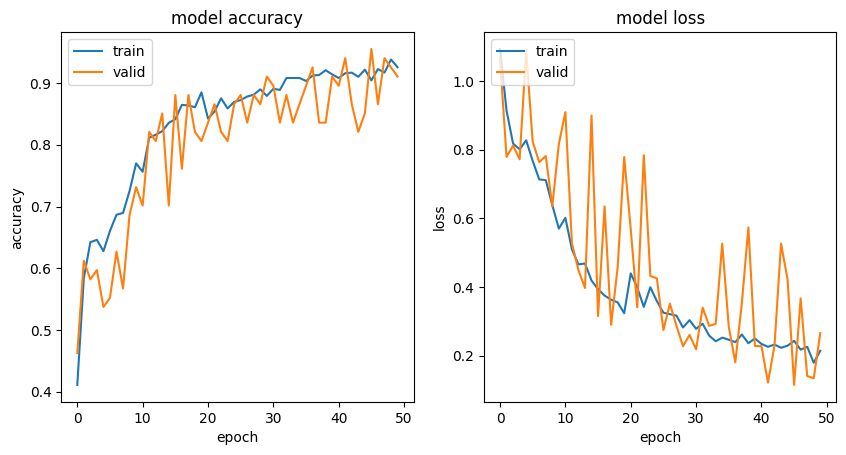

17/17 [==============================] - 4s 200ms/step - loss: 0.1784 - accuracy: 0.9265
[Validation loss: 0.114476 , Validation acc.:95.52%]
[Test loss: 0.178383 , Test acc.:92.65%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

# Cenário 2 : Using pre-trained network as feature extractor

(Congelamos tudo)

In [ ]:
# Ajustando o VGG16 aos dados de treino, além de remover o fine-tuning
base_model = VGG16(input_shape=(224,224,3))

# Freeze the convolutional base model
base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

Start training
3/3 [==============================] - 1s 96ms/step - loss: 2.8915 - accuracy: 0.4478
initial loss: 2.89
initial accuracy: 0.45
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 2.0683 - accuracy: 0.4101
Epoch 1: val_accuracy improved from -inf to 0.52239, saving model to best_model.h5
33/33 [==============================] - 9s 189ms/step - loss: 2.0683 - accuracy: 0.4101 - val_loss: 1.9741 - val_accuracy: 0.5224
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.6576 - accuracy: 0.4594
Epoch 2: val_accuracy improved from 0.52239 to 0.56716, saving model to best_model.h5
33/33 [==============================] - 6s 167ms/step - loss: 1.6576 - accuracy: 0.4594 - val_loss: 1.6767 - val_accuracy: 0.5672
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.6345 - accuracy: 0.4845
Epoch 3: val_accuracy did not improve from 0.56716
33/33 [==============================] - 6s 174ms/step - loss: 1.6345 - accuracy: 0.4845 - va

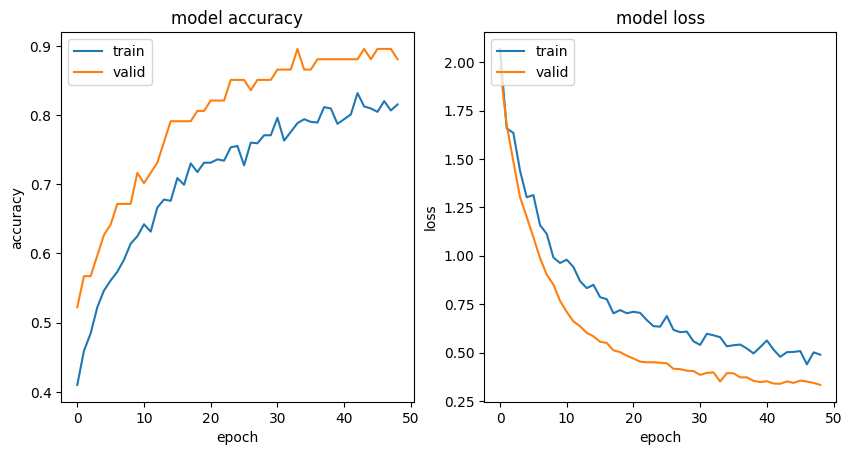

17/17 [==============================] - 4s 142ms/step - loss: 0.6791 - accuracy: 0.7563
[Validation loss: 0.351060 , Validation acc.:89.55%]
[Test loss: 0.679127 , Test acc.:75.63%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

# Cenário 3.1

In [ ]:
# Freeze up to specific layer of the base model
base_model = VGG16(input_shape=(224,224,3))
base_model = freeze_layer(base_model,'block5_conv1') # 3.1
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

Start training
3/3 [==============================] - 1s 87ms/step - loss: 6.6947 - accuracy: 0.3134
initial loss: 6.69
initial accuracy: 0.31
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1130 - accuracy: 0.5648
Epoch 1: val_accuracy improved from -inf to 0.71642, saving model to best_model.h5
33/33 [==============================] - 9s 198ms/step - loss: 1.1130 - accuracy: 0.5648 - val_loss: 0.6174 - val_accuracy: 0.7164
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.5121 - accuracy: 0.7969
Epoch 2: val_accuracy improved from 0.71642 to 0.82090, saving model to best_model.h5
33/33 [==============================] - 7s 191ms/step - loss: 0.5121 - accuracy: 0.7969 - val_loss: 0.3847 - val_accuracy: 0.8209
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8743
Epoch 3: val_accuracy improved from 0.82090 to 0.88060, saving model to best_model.h5
33/33 [==============================] - 8s 194ms/step - l

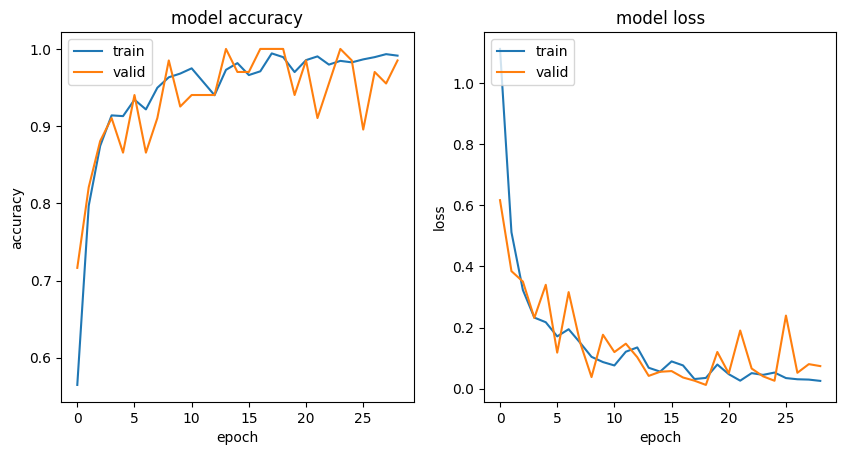

17/17 [==============================] - 4s 135ms/step - loss: 0.0226 - accuracy: 0.9923
[Validation loss: 0.041519 , Validation acc.:100.00%]
[Test loss: 0.022569 , Test acc.:99.23%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

# Cenário 3.2

In [ ]:
# Freeze up to specific layer of the base model
base_model = VGG16(input_shape=(224,224,3))
base_model = freeze_layer(base_model,'block4_conv1') # 3.2
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0   

Start training
3/3 [==============================] - 1s 93ms/step - loss: 6.0026 - accuracy: 0.3582
initial loss: 6.00
initial accuracy: 0.36
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.0119 - accuracy: 0.5251
Epoch 1: val_accuracy improved from -inf to 0.85075, saving model to best_model.h5
33/33 [==============================] - 12s 264ms/step - loss: 1.0119 - accuracy: 0.5251 - val_loss: 0.4754 - val_accuracy: 0.8507
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.7331
Epoch 2: val_accuracy did not improve from 0.85075
33/33 [==============================] - 9s 237ms/step - loss: 0.5994 - accuracy: 0.7331 - val_loss: 0.4011 - val_accuracy: 0.8358
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8240
Epoch 3: val_accuracy improved from 0.85075 to 0.88060, saving model to best_model.h5
33/33 [==============================] - 9s 248ms/step - loss: 0.4309 - accuracy: 0.8240 - v

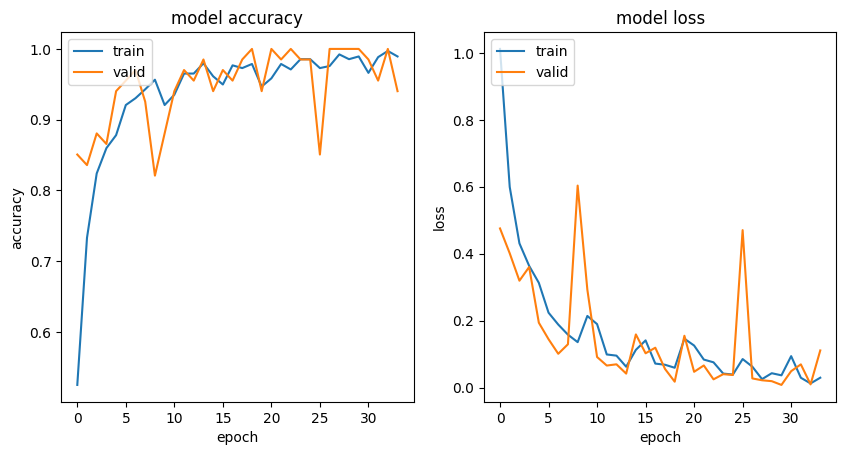

17/17 [==============================] - 4s 143ms/step - loss: 0.0330 - accuracy: 0.9845
[Validation loss: 0.017474 , Validation acc.:100.00%]
[Test loss: 0.032977 , Test acc.:98.45%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

# Cenário 3.3

In [ ]:
# Freeze up to specific layer of the base model
base_model = VGG16(input_shape=(224,224,3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

Start training
3/3 [==============================] - 2s 87ms/step - loss: 4.2274 - accuracy: 0.2537
initial loss: 4.23
initial accuracy: 0.25
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1469 - accuracy: 0.4758
Epoch 1: val_accuracy improved from -inf to 0.55224, saving model to best_model.h5
33/33 [==============================] - 21s 469ms/step - loss: 1.1469 - accuracy: 0.4758 - val_loss: 0.8198 - val_accuracy: 0.5522
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.6731
Epoch 2: val_accuracy improved from 0.55224 to 0.80597, saving model to best_model.h5
33/33 [==============================] - 17s 483ms/step - loss: 0.7459 - accuracy: 0.6731 - val_loss: 0.5455 - val_accuracy: 0.8060
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.7350
Epoch 3: val_accuracy did not improve from 0.80597
33/33 [==============================] - 16s 456ms/step - loss: 0.6552 - accuracy: 0.7350 -

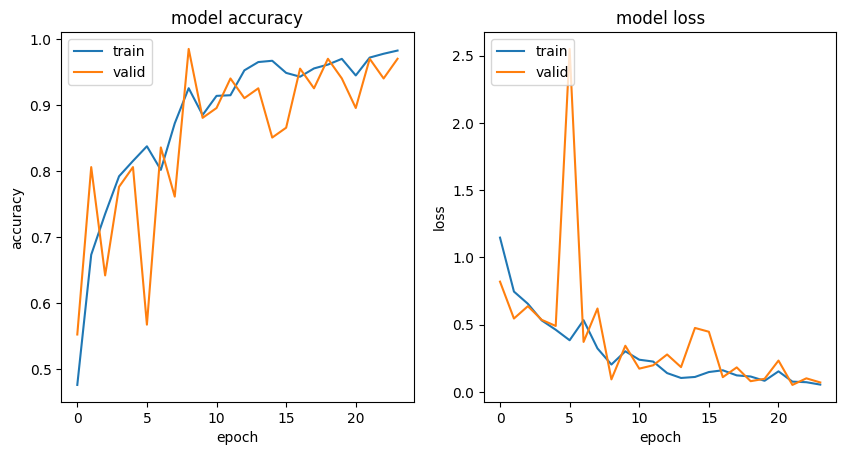

17/17 [==============================] - 3s 134ms/step - loss: 0.1699 - accuracy: 0.9342
[Validation loss: 0.093335 , Validation acc.:98.51%]
[Test loss: 0.169884 , Test acc.:93.42%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)